Check Python version

In [43]:
!python --version

Python 3.10.14


Import libraries

In [44]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [45]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [46]:
train_df = pd.read_csv(file_name)

In [47]:
train_df.shape

(144, 2)

In [48]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [49]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [50]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [51]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [52]:
train_df[target_col] = train_df[target_col].astype(float)

In [53]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

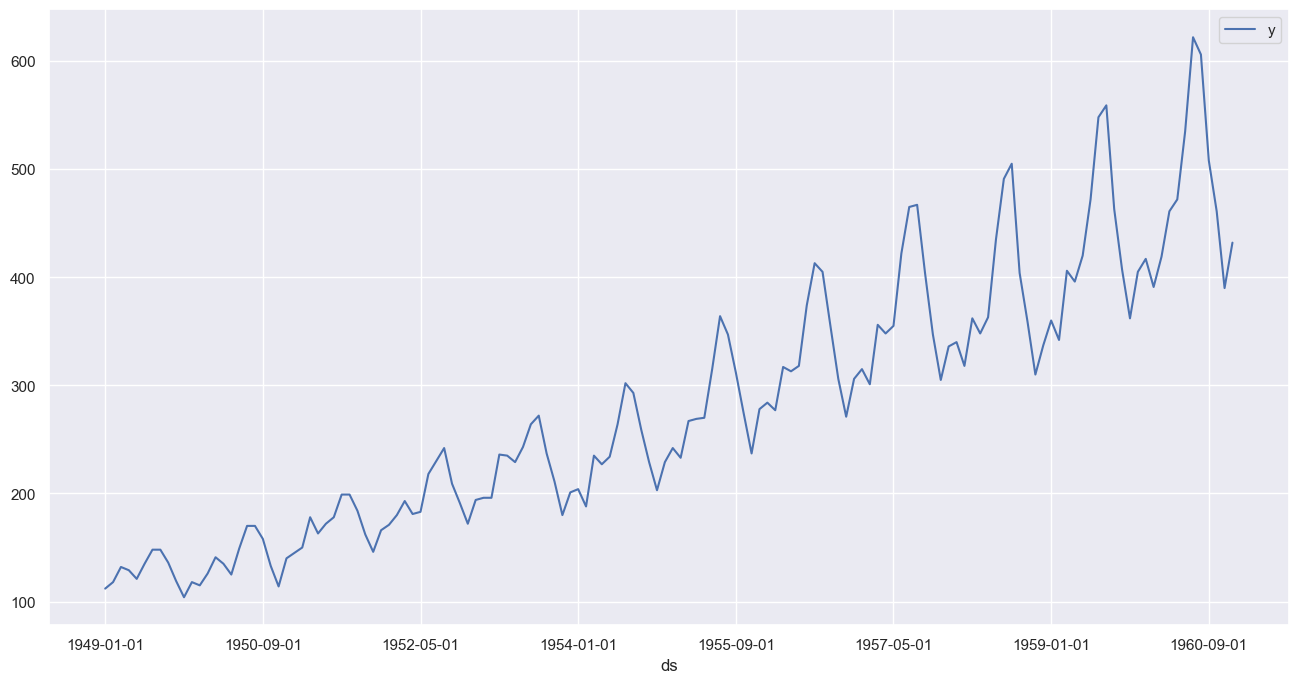

In [54]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [55]:
train_data = []

In [56]:
for value in train_df.values:
    train_data.append(list(value))

In [57]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [58]:
# Default model request
# model_request = {
#     'type': 'meta_lr',
#     'scorers': ['smape', 'mase'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_naive'},
#             {'type': 'darts_seasonalnaive'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autoets'},
#         ],
#     },
# }

# Onboard NeuralProphet customized model request
# np_external_model_request = {
#     'params': {
#       'changepoints_range': 0.2,
#       'epochs': 2,
#       'growth': 'off'
#     },
#     'metrics': [],
#     'type': 'neuralprophet',
# }
# np_external_model_request = None

# Customized model request
model_request = {
    'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
    'scorers': ['mase', 'smape'],
    'params': {
        'preprocessors': [
            {'type': 'dartsimputer'},
            {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            {'type': 'darts_naive'},
            {'type': 'darts_seasonalnaive'},
            {'type': 'darts_autotheta'},
            {'type': 'stats_autotheta'},
            {'type': 'darts_autoets'},
            {'type': 'stats_autoets'},
            {'type': 'darts_autoarima'},
            {'type': 'stats_autoarima'},
            {'type': 'darts_autoces'},

            {'type': 'darts_kalman'},
            
            {'type': 'darts_catboost'},            
            # {'type': 'darts_tbats'},
            # {'type': 'darts_linearregression'},
            {'type': 'darts_lightgbm',
             'params': {
                 'lags': 12,
                 'output_chunk_length': 6,
                 'verbose': -1
            }}
            # {'type': 'neuralprophet',
            #  'external_params': np_external_model_request
            # }  # Onboard NeuralProphet external service
        ],
    },
}

This is for JSON model_request

In [59]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [60]:
# file_path = 'model_request.yaml'
# # For reading the model request from a yaml file
# with open(file_path, 'r') as file:
#     model_request = yaml.safe_load(file)

# print(model_request)

Train API JSON Payload

In [61]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [62]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [63]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [64]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [65]:
%%time
response = requests.post(url, json=api_json,verify=False)
print(response)
print()

<Response [200]>

CPU times: total: 0 ns
Wall time: 1min 4s


In [66]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEBCHqnGAAAABAAplkKABgAAAAxSAUA+p0AAD+AAGVsaZOMb5Rsb4xtlARhaZRzcmGUKIwudG2UTZNwbx94lEmMLmRtSWWMFW9pDHSMjHlDKCSUiQNK/0NulGQuLh9ld22TdGQoZHOUX2V5k2FhYZRplE4CUk7/KEt0AJRoiB9o/wCUlIDGxAMBamjRzsw1MpyZl9fUPTukoZ8IBm9sah+qpxAOd3Vy29lCPz0SD3h239zaQ0Gqp6Xl4ktJsrCtFh8UfXp4uLUeHIWDgOnnUE5Li4ny71hWU726IyEe8/BZVx/AvrskIouIhsbELSqTkY739V5cWZmXAP1mZGLLyDEvLB9satPROjc1npsEAgDU0js4oZ+dBgNsfWVhBQqMhpSMYR9lXXNsF2RllAdllChlYWyMLnJlKWhsYZQbaGgBaAluYcDDHx5ohwB0hgZ9c2+UZWdoaAFoc3NpfYgOKChohSgwNWggH1UthzH/fUuGJpSFlEv//24BiRanS9wer/GCE1XmKLlKH+5/wVKUJbb4ictc7ZEiZPU3yFmbLG7/kIMUVucpukuNHx5g8YImt/mKzF3uMMEDlCXJWpwtbwCR02SmN8hs/T/QHxKjNHYHSdprXu8xwgSVJmj5O8xdAZLUZac4yQuc3m8AH6Q1dwhK22yuP4ESo0fYGqvtfg9R4iS1RjnKDJ3fcAFDH9QWlBtfbHNvbpRgaJRofYiMU5QDAwQpaGgglEuJaF2FEiiQXSgAlGholCiUaIUoMGFofYjgDB0BaKNg/B9oaGiMjC5hC2WBYWwBdHKUIm9yZ25pZ5QoaWV0ZVRlfR9tYhVjYQlhTm8oci5leGV9bQUUY2VQZGEpBTpoDYyUTh9KlAGUS1KUiQT/S3N0QmsD6ICIICfAWWD4AJgxFa61Th9V7oaNJi3GXkPc43uDG7S7VFvzjAKbojpC2nN6ExqySx8wyM9obwigqEBI4Hld9v2WnTbO1W51D

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [67]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [68]:
model = train_json_out['model']

Forecast API JSON Payload

In [69]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [70]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [71]:
%%time
response = requests.post(url, json=api_json,verify=False)
print(response)
print()

<Response [200]>

CPU times: total: 0 ns
Wall time: 2.14 s


In [72]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1961-01-01', 448.16813026033213],
  ['1961-02-01', 431.67572269565534],
  ['1961-03-01', 475.6867480111262],
  ['1961-04-01', 487.30944266531145],
  ['1961-05-01', 499.6856624141079],
  ['1961-06-01', 558.1225115254034],
  ['1961-07-01', 624.2140157933504],
  ['1961-08-01', 618.0060001386514],
  ['1961-09-01', 537.6989770699194],
  ['1961-10-01', 481.73245280764326],
  ['1961-11-01', 424.3770535917045],
  ['1961-12-01', 464.6577211365751],
  ['1962-01-01', 475.7328317042215],
  ['1962-02-01', 459.3664235485412],
  ['1962-03-01', 501.99511703387225],
  ['1962-04-01', 516.4686324580958],
  ['1962-05-01', 528.3806858872234],
  ['1962-06-01', 588.2154873513465],
  ['1962-07-01', 655.4619049981408],
  ['1962-08-01', 648.9198433224503],
  ['1962-09-01', 568.3051504156228],
  ['1962-10-01', 512.3060443886176],
  ['1962-11-01', 451.4016753598452],
  ['1962-12-01', 492.01818705002677]]}

Combine forecast dates and output

In [73]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [74]:
forecast_df.shape

(24, 2)

In [75]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [76]:
forecast_df.head()

,ds,y
0,1961-01-01,448.168130
1,1961-02-01,431.675723
2,1961-03-01,475.686748
3,1961-04-01,487.309443
4,1961-05-01,499.685662


In [77]:
forecast_df.tail()

,ds,y
19,1962-08-01,648.919843
20,1962-09-01,568.305150
21,1962-10-01,512.306044
22,1962-11-01,451.401675
23,1962-12-01,492.018187


Plot train and forecast side-by-side

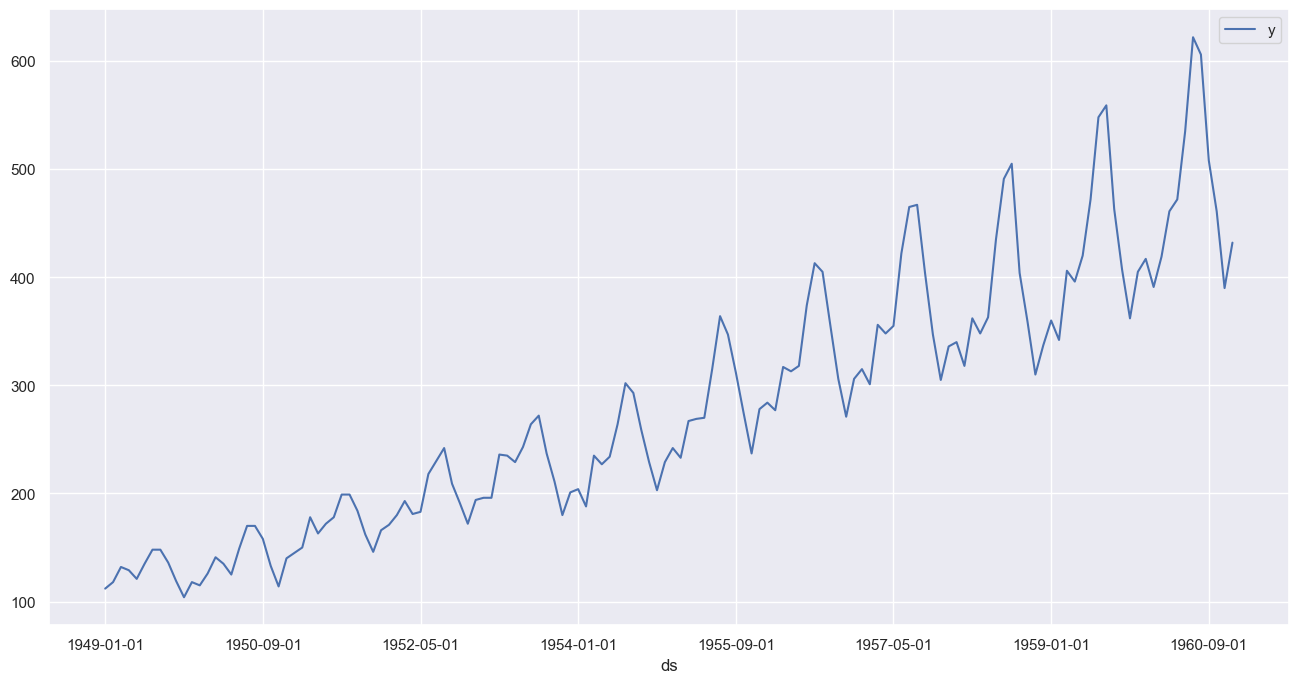

In [78]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

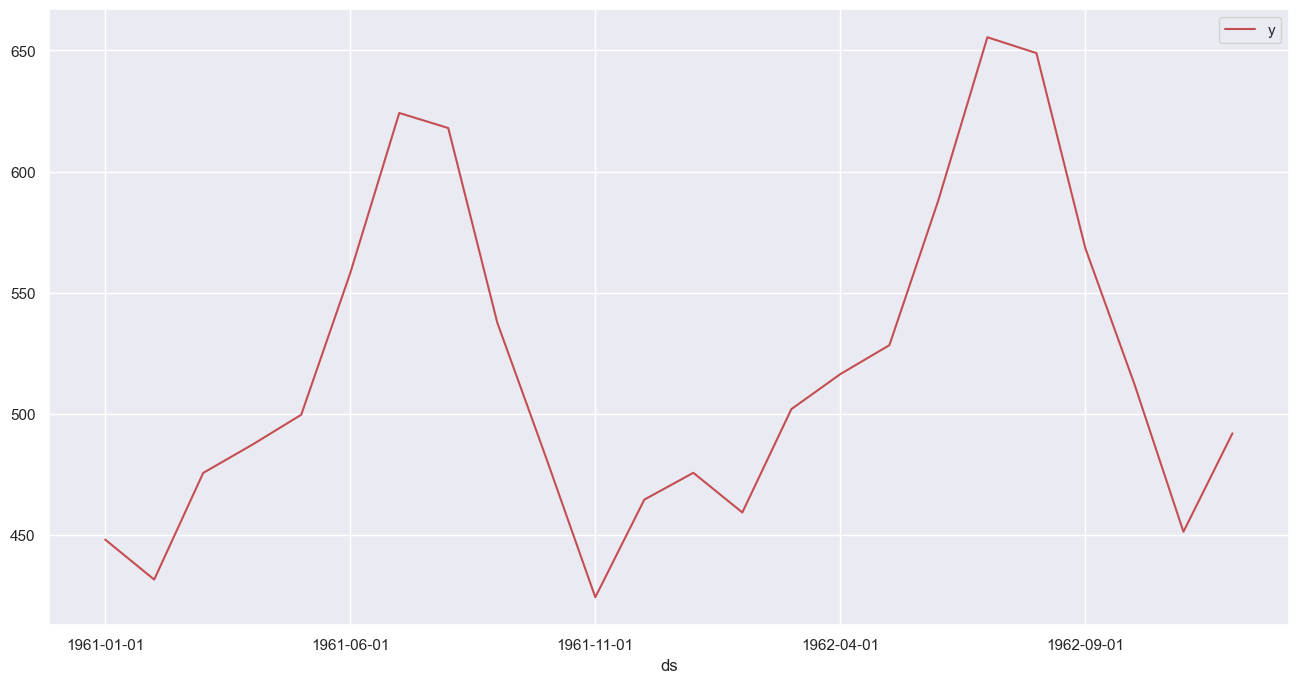

In [79]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [80]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [81]:
df.shape

(168, 3)

In [82]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [83]:
df.tail()

,ds,y,color
163,1962-08-01,648.919843,r
164,1962-09-01,568.305150,r
165,1962-10-01,512.306044,r
166,1962-11-01,451.401675,r
167,1962-12-01,492.018187,r


Plot combined train and forecast sets with the vertical black line as the cut-off

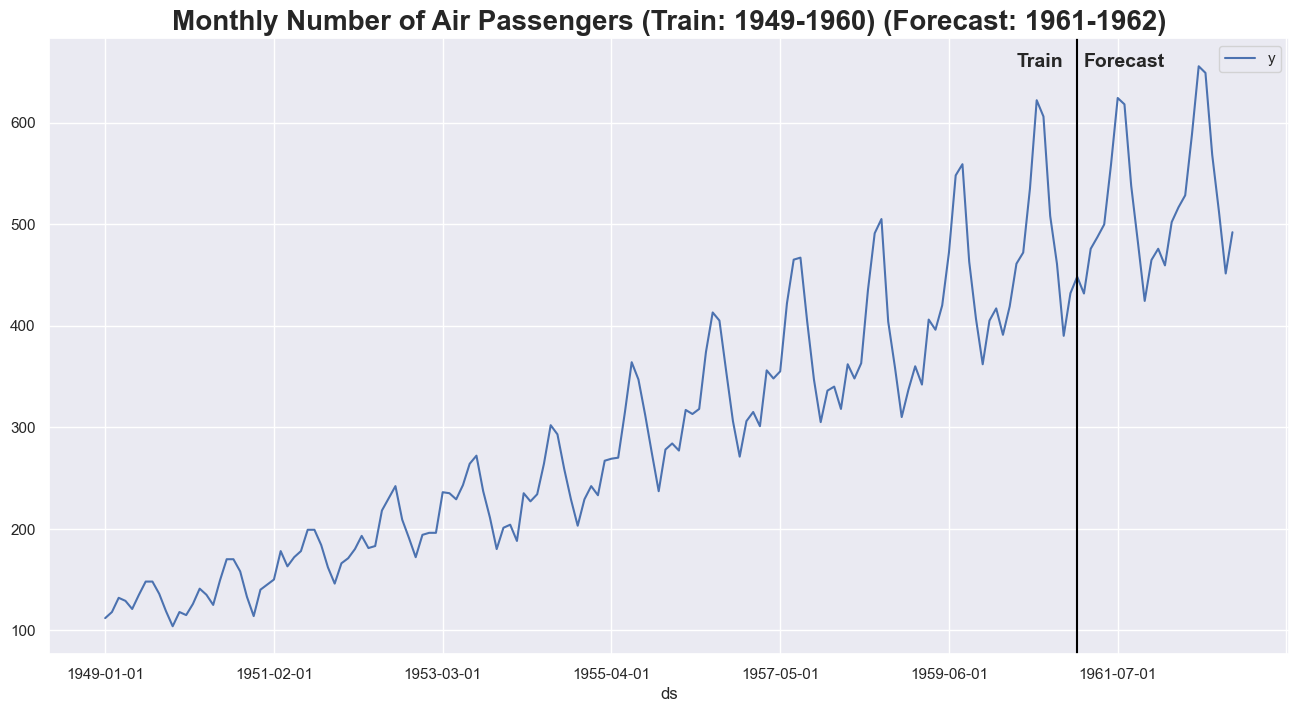

In [84]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Forecast: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();